Lab 6

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from PIL import Image

In [ ]:
image_path = "Picture1.jpg"
image = cv2.imread(image_path)

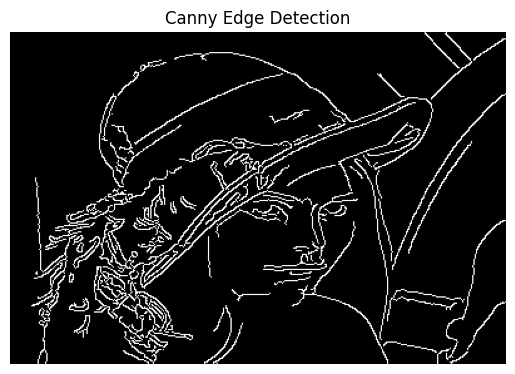

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5,5), 0)
edges = cv2.Canny(blurred, 50, 150)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()

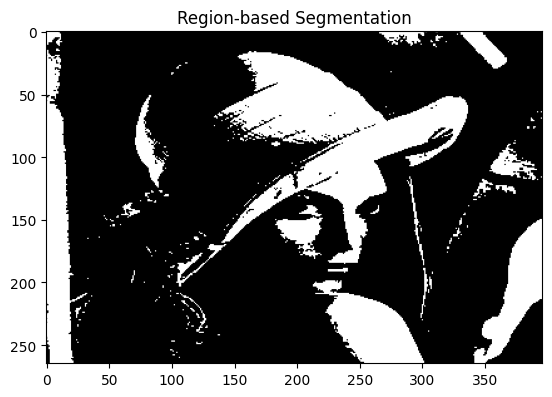

In [ ]:
_, segmented = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

plt.imshow(segmented, cmap='gray')
plt.title('Region-based Segmentation')
plt.show()


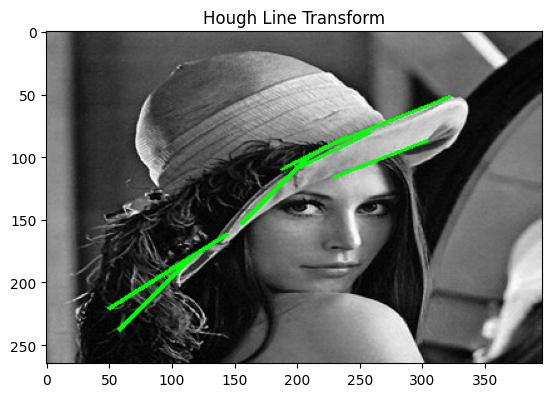

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10)

line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(line_image)
plt.title('Hough Line Transform')
plt.show()


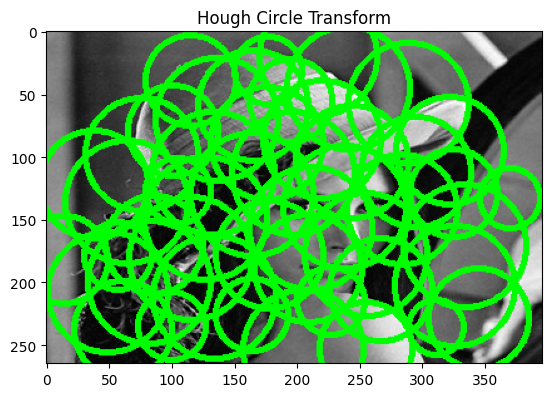

In [ ]:
circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=20, maxRadius=50)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    circle_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for (x, y, r) in circles:
        cv2.circle(circle_image, (x, y), r, (0, 255, 0), 4)

plt.imshow(circle_image)
plt.title('Hough Circle Transform')
plt.show()

In [ ]:
import cv2
import numpy as np
import os
from keras.applications import ResNet50
from keras.preprocessing import image as keras_image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow

In [ ]:
def yolo_object_detection(image_path):
    # Check if YOLO files exist
    if not os.path.exists('yolov3.weights') or not os.path.exists('yolov3.cfg'):
        print("Error: YOLO files not found! Please ensure yolov3.weights and yolov3.cfg are in the current directory.")
        return

    # Load YOLO model
    net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at {image_path} not found.")
        return

    # Prepare image for YOLO
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Processing YOLO output
    height, width, channels = image.shape
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # Append values for the final bounding box
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove redundant boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Use cv2_imshow for displaying the image in Colab
    cv2_imshow(image)  # Show the image in Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
def rcnn_object_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at {image_path} not found.")
        return

    # Convert to grayscale (used for regions in RCNN)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    regions = []  # List to store regions for object detection

    # Example of dividing the image into regions (50x50 pixel blocks)
    for i in range(0, image.shape[0], 50):
        for j in range(0, image.shape[1], 50):
            region = image[i:i+50, j:j+50]
            if region.shape[0] != 50 or region.shape[1] != 50:
                continue
            regions.append(region)

    # Load pre-trained ResNet50 model for feature extraction
    model = ResNet50(weights='imagenet')

    for region in regions:
        # Pre-process the region for the model
        region_resized = cv2.resize(region, (224, 224))
        img_array = keras_image.img_to_array(region_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Predict using the CNN (ResNet50)
        preds = model.predict(img_array)

        decoded_preds = decode_predictions(preds, top=1)[0]
        label = decoded_preds[0][1]  # Class name
        print(f"Predicted class for region: {label}")

        # Draw bounding box and label on the image
        cv2.rectangle(image, (i, j), (i + 50, j + 50), (255, 0, 0), 2)
        cv2.putText(image, label, (i, j-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Use cv2_imshow for displaying the image in Colab
    cv2_imshow(image)  # Show the image in Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()



Running YOLO object detection...
Error: YOLO files not found! Please ensure yolov3.weights and yolov3.cfg are in the current directory.
Running RCNN object detection...
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted class for region: punching_bag
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Predicted class for region: nematode
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Predicted class for region: nematode
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted class for region: nematode
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted class for region: plane
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predicted class for region: milk_can
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Predicted class for region: pick
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted class for region: bearskin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predicted class for region: nematode
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted class 

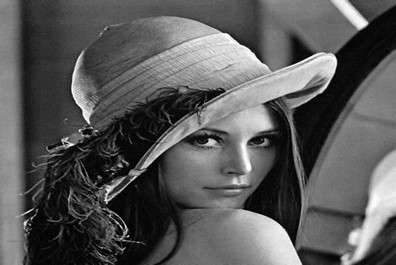

In [ ]:
def main():
    image_path = "Picture1.jpg"  # Replace with the correct image path

    # Run YOLO object detection
    print("Running YOLO object detection...")
    yolo_object_detection(image_path)

    # Run RCNN object detection
    print("Running RCNN object detection...")
    rcnn_object_detection(image_path)

if __name__ == "__main__":
    main()